In [1]:
import os
import copy
from collections import OrderedDict
from tabulate import tabulate
import numpy as np
import math
import matplotlib.pyplot as plt
import flopy
import flopy.plot.styles as styles
from dis2disu import Dis2Disu

In [2]:
ws = './disu_model'

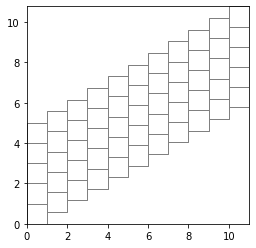

In [3]:
# Lx is the full width of the model. The grid spacing in the x direction is
# delr = Lx / ncol, and so the horizontal distance between the left and right
# boundary conditions is Lx - delr. The cells in the channel are square, i.e.,
# delz_chan = delr. The cross-sectional model has unit thickness "into the page,"
# i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay_chan * delz_chan.
# Theta is the angle (deg) at which the channel slopes, and so the width of the
# true" channel measured perpendicularly to the slope, i.e., the width available 
# for flow along the slope of the channel,is nlay_chan * delz_chan * cos(theta).
# The increase in elevation (vertical offset) as one moves a column to the right
# within the channel is delr * tan(theta).

# adjustable grid parameters
#nlay_chan, ncol = 21, 45
nlay_chan, ncol = 5, 11         # number of layers in channel, and number of columns in model
Lx = 11.0                       # full horizontal width of model
theta = 30.                     # angle of inclination of channel
domain = False                   # option to include "domain" (True) or not (False)
k_dom = 1e-6                    # domain conductivity
#k_dom = 1.                      # domain_conductivity

# grid parameters intended to remain fixed
nrow = 1                        # model is one row deep "into the page"
delc = 1.                       # model has unit width "into the page"

# computed grid parameters
if domain:
    nlay_dom_upper = nlay_chan                      # number of layers in upper domain
else:
    nlay_dom_upper = 0
nlay_dom_lower = nlay_dom_upper                     # number of layers in lower domain
nlay = nlay_chan + nlay_dom_upper + nlay_dom_lower  # total number of layers
delr = float(Lx / ncol)                             # horizontal cell size
delz_chan = delr                                    # vertical cell size in channel
zoffset = delr * math.tan(theta * math.pi / 180.)   # vertical offset between cells in channel
zthick = nlay_chan * delz_chan                      # vertical thickness of channel
zspan = (ncol - 1) * zoffset + zthick               # total vertical span of channel

# set tops, bottoms, and conductivities
botm = np.empty((nlay, nrow, ncol))
cond = np.ones((nlay, nrow, ncol))                  # unit conductivity in channel, set as default here
if domain:
    # upper domain
    Lz = zspan + 2. * zthick                        # total height of model
    top_chan = 2. * zthick + np.linspace(0., (ncol - 1) * zoffset, ncol)
    top_chan = top_chan.reshape((nrow, ncol))       # top of channel
    top = np.ones((nrow, ncol)) * Lz                # top of model
    dz = (top - top_chan) / nlay_dom_upper          # vertical cell size varies by column in domain
    botm[0] = top - dz                              # bottom of first layer is calculated using top
    cond[0] = k_dom
    for klay in range(1, nlay_dom_upper):
        botm[klay] = botm[klay - 1] - dz
        cond[klay] = k_dom
    # prepare to continue with channel discretization
    klaycontinue = nlay_dom_upper
else:
    # initialize channel discretization
    Lz = zspan                                     # total height of model
    top_chan = zthick + np.linspace(0., (ncol - 1) * zoffset, ncol)
    top_chan = top_chan.reshape((nrow, ncol))      # top of channel
    top = top_chan                                 # top of model is top of channel
    botm[0] = top - delz_chan                      # bottom of first layer is calculated using top
    # prepare to continue channel discretization
    klaycontinue = 1
# channel
for klay in range(klaycontinue, nlay_dom_upper + nlay_chan):
    botm[klay] = botm[klay - 1] - delz_chan
    #cond[klay] = k_dom   # kluge test
if domain:
    # lower domain
    dz = (top_chan - zthick) / nlay_dom_lower     # vertical cell size varies by column in domain
    for klay in range(nlay_dom_upper + nlay_chan, nlay):
        botm[klay] = botm[klay - 1] - dz
        cond[klay] = k_dom

# plot dis grid
delr = delr * np.ones(ncol, dtype=float)
delc = delc * np.ones(nrow, dtype=float)
mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                          top=top, botm=botm)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
xs = flopy.plot.PlotCrossSection(modelgrid=mgs, ax=ax, line={"row":0})
xs.plot_grid()

In [4]:
# scenario parameters
# scenario names -- keys of parameters dictionary are scenario names
#                   built automatically from scenario options
# crossflow -- analytical flow is across the channel, i.e., crossflow (True)
#              or along the channel, i.e., axial flow (False)
# staggered -- vertically staggered grid, i.e., cross-connections (True)
#              or not, i.e., vertically offset (False)
# xt3d -- xt3d on (True) or off, i.e., standard formulation (False)

# scenario options
options = [
    {
        "optionname": "crossflow",
        "optionstrings": {
            False: "-af",
            True: "-cf",
        },   
    },
    {
        "optionname": "staggered",
        "optionstrings": {
            False: "-vo",
            True: "-vs",
        },
    },
    {
        "optionname": "xt3d",
        "optionstrings": {
            False: "-s",
            True: "-x",
        },
    },
]

# function that builds parameters (ordered) dictionary from scenario options
def build_parameters(options, *args, ioption=0):
    if ioption == 0:
        # initial call is without args, so set things up
        noptions = len(options)
        name = [""] * (noptions + 1)
        name[0] = "disu"
        if domain:
            name[0] = name[0] + "-d"
        parameters = OrderedDict()
        pdict = OrderedDict()
        args = (name, pdict, parameters)
    else:
        # after initial call, args is passed, so extract things from it
        args = args[0]
        name, pdict, parameters = args
    # loop over option values
    for optionval in [False, True]:
        # update parameter sub-dictionary and scenario name array
        pdict[options[ioption]["optionname"]] = optionval
        name[ioption + 1] = name[ioption] + options[ioption]["optionstrings"][optionval]
        if ioption == len(options) - 1:
            # last option, so copy parameter sub-dictionary to parameters with scenario name as key
            parameters[name[ioption + 1]] = copy.deepcopy(pdict)
        else:
            # call this routine recursively for the next option
            ioptionnext = ioption + 1
            parameters = build_parameters(options, args, ioption=ioptionnext)
    return parameters

# build parameters dictionary
parameters = build_parameters(options)

In [5]:
def calculate_head_analyt(crossflow):
    global head_analyt

    # Analytical head a la Bardot et al (2022),
    # assuming a head gradient of magnitude -1.
    # axial flow: head = - cos(theta) * x - sin(theta) * z
    # crossflow: head = sin(theta) * x - cos(theta) * z

    thetarad = theta * math.pi / 180.
    sintheta = math.sin(thetarad)
    costheta = math.cos(thetarad)
    if crossflow:
        hgradx = sintheta
        hgradz = -costheta
    else:
        hgradx = -costheta
        hgradz = -sintheta

    head_analyt = []
    for klay in range(nlay):
        for jcol in range(ncol):
            xc = float(jcol + 0.5) * delr[0]
            if klay == 0:
                ztop = top[0][jcol]
            else:
                ztop = botm[klay - 1][0][jcol]
            zc = 0.5 * (ztop + botm[klay][0][jcol])
            hc = hgradx * xc + hgradz * zc
            head_analyt.append(hc)

    return

In [6]:
def print_spdis_summary(qx, qy, qz, crossflow):

    jcolmid = int(ncol / 2)
    klaymid = int(nlay / 2)
    
    qmagmin = qangmin = qmagmid = float('inf')
    qmagmax = qangmax = qangmid = float('-inf')
    qmagavg = qangavg = 0.
    ncount = 0
    icell = -1
    #for klay in range(nlay):
    for klay in range(nlay_dom_upper, nlay_dom_upper + nlay_chan):
        for jcol in range(ncol):
            icell += 1
            qqx = qx[icell]
            qqz = qz[icell]
            qmag = math.sqrt(qqx * qqx + qqz * qqz)
            if (qqx == 0.):
                if (qqz == 0.):
                    qang = 0.
                elif (qqz > 0.):
                    qang = 90.
                else:
                    qang = -90.
            else:
                #qang = math.atan(qqz / qqx) * 180. / math.pi
                qang = math.atan2(qqz, qqx) * 180. / math.pi
            ncount += 1
            qmagmin = min([qmagmin, qmag])
            qmagmax = max([qmagmax, qmag])
            qmagavg += qmag
            qangmin = min([qangmin, qang])
            qangmax = max([qangmax, qang])
            qangavg += qang
            if (klay == klaymid) and (jcol == jcolmid):
                qmagmid = qmag
                qangmid = qang
    qmagavg = qmagavg / ncount
    qangavg = qangavg / ncount
    qmagana = 1.
    #qangana = math.atan2(top_chan[0][1] - top_chan[0][0], delr[0]) * 180. / math.pi
    qangana = theta
    if crossflow:
        qangana += 90.

    print ("\nSPECIFIC DISCHARGE:")
    qdata = [
        ["analytical", qmagana, qangana],
        ["mid-channel", qmagmid, qangmid],
        ["avg channel", qmagavg, qangavg],
        ["min channel", qmagmin, qangmin],
        ["max channel", qmagmax, qangmax],
    ]
    qhead = ["", "magnitude", "angle",]
    print(tabulate(qdata, headers=qhead, tablefmt="simple", floatfmt=".14f"))
    
    return

In [7]:
def build_model(sim_name, xt3d, staggered, crossflow):
    global d2d
    
    # convert to disu grid
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered)
    
    sim_ws = os.path.join(ws, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name='./bin/mf6')
    tdis = flopy.mf6.ModflowTdis(sim)
    #ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab')
    ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab',
                              # inner_dvclose=1e-12, inner_rclose=1e-12, # kluge test
                              )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name,
                               save_flows=True, print_flows=True)
    disu = flopy.mf6.ModflowGwfdisu(gwf, **d2d.get_gridprops_disu6())
    ic = flopy.mf6.ModflowGwfic(gwf)
    npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                                  xt3doptions=xt3d, k=cond,
                                  angle1=0., angle2=0., angle3=0.)

    # Set boundary heads to analytical values
    calculate_head_analyt(crossflow)
    spd = []
    # specify heads along left and right sides of model
    for klay in range(nlay):
        icleft = klay*ncol
        icright = icleft + ncol - 1
        spd.append([(icleft,), head_analyt[icleft]])
        spd.append([(icright,), head_analyt[icright]])
    # if domain included or if crossflow, specify heads
    # along top and bottom of model
    if domain or crossflow:
        for jcol in range(1, ncol - 1):
            ictoplay = jcol
            icbotlay = ictoplay + (nlay - 1) * ncol
            spd.append([(ictoplay,), head_analyt[ictoplay]])
            spd.append([(icbotlay,), head_analyt[icbotlay]])
    chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=spd)

    budget_file = sim_name + '.bud'
    head_file = sim_name + '.hds'
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord=budget_file,
                                head_filerecord=head_file,
                                saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                                printrecord=[('BUDGET', 'ALL'), ('HEAD', 'ALL')],)

    return sim

In [8]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_model(key, **params)
    sim.write_simulation(silent=silent)
    success, buff = sim.run_simulation(silent=silent, report=True)
    if not success:
        print(buff)
    else:
        plot_results(idx, sim)

In [9]:
def plot_results(idx, sim):

    sim_name = list(parameters.keys())[idx]
    sim_ws = os.path.join(ws, sim_name)
    gwf = sim.get_model(sim_name)
    staggered = parameters[sim_name]["staggered"]
    crossflow = parameters[sim_name]["crossflow"]
    
    simdata = [["sim_name", sim_name]]
    for key, value in parameters[sim_name].items():
        simdata.append([key, value])
    print(tabulate(simdata, tablefmt="simple", floatfmt=".14f"))
    
    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    # if cross-connections, recalculate qx taking into account overlap areas
    if staggered:
        flowja = bud.get_data(text='FLOW-JA')[0][0][0]
        gp = d2d.get_gridprops_disu6()
        iac = gp["iac"]
        ja = gp["ja"]
        ihc = gp["ihc"]
        topbycell = gp["top"]
        botbycell = gp["bot"]
        hwva = gp["hwva"]
        iconn = -1
        icell = -1
        for il in iac:
            icell += 1
            qxnumer = 0.
            qxdenom = 0.
            for ilnbr in range(il):
                iconn += 1
                if ihc[iconn] == 2:
                    inbr = ja[iconn]
                    if (inbr == icell):
                        continue
                    dz = min(topbycell[icell], topbycell[inbr]) - max(botbycell[icell], botbycell[inbr])
                    qxincr = flowja[iconn] / (hwva[iconn] * dz)
                    # equal weight given to each face, but could weight by distance instead
                    if (inbr < icell):
                        qxnumer += qxincr
                    else:
                        qxnumer -= qxincr
                    qxdenom += 1.
            qx[icell] = qxnumer / qxdenom

    # print specific discharge summary
    print_spdis_summary(qx, qy, qz, crossflow)

    # plot head and specific discharge and save figure
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax,
                                     line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    xs.plot_grid()
    cb = xs.plot_array(head, cmap="jet")
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Head, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
    #xs.plot_vector(qx, qy, qz, scale=10, normalize=False, color="black",
    xs.plot_vector(qx, qy, qz, normalize=False, color="black",
                   width=0.0075, headwidth=3, headlength=5, headaxislength=4)
    fig.tight_layout()
    figure_ext = ".png"
    fpth0 = os.path.join(
        "..", "figures", "{}-head{}".format(sim_name, figure_ext)
    )
    plt.close(fig)
    fig.savefig(fpth0)

    # plot head error and save figure
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax,
                                     line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    xs.plot_grid()
    cb = xs.plot_array(head - np.array(head_analyt), cmap="jet")
    
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Error, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
    fig.tight_layout()
    figure_ext = ".png"
    fpth1 = os.path.join(
        "..", "figures", "{}-error{}".format(sim_name, figure_ext)
    )
    plt.close(fig)
    fig.savefig(fpth1)

    # display the two saved figures inline in a combined figure
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].set_axis_off()
    ax[0].imshow(plt.imread(fpth0))
    ax[1].set_axis_off()
    ax[1].imshow(plt.imread(fpth1))
    plt.show()
    
    return

---------  ------------
sim_name   disu-af-vo-s
crossflow  False
staggered  False
xt3d       False
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.15603852061285   2.75709023168378
avg channel  1.18265667221260   9.55267276778834
min channel  0.83185457115262   1.71639758816658
max channel  1.69971070766811  36.13083931076601


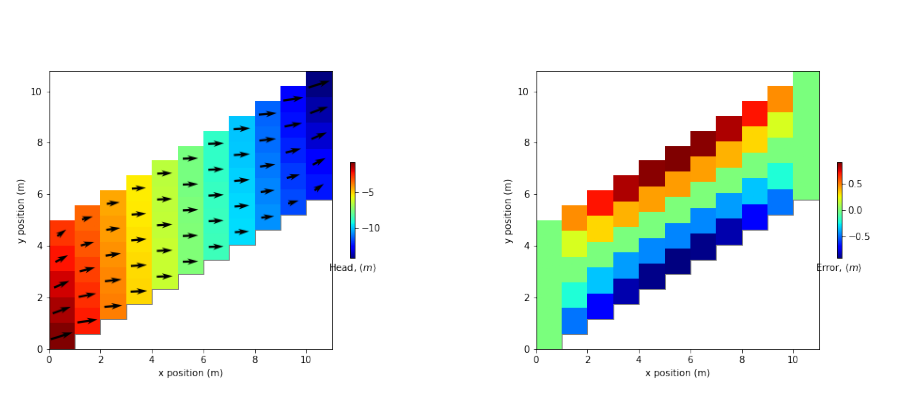

---------  ------------
sim_name   disu-af-vo-x
crossflow  False
staggered  False
xt3d       True
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.05467811026900   2.96272068225794
avg channel  1.09262198305808  10.37710520620107
min channel  0.75465755895654   1.89192925657518
max channel  1.62049326129239  39.67033147056102


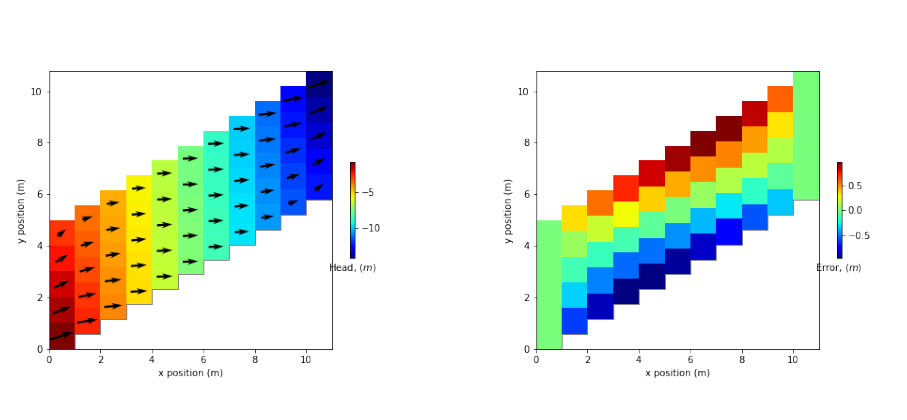

---------  ------------
sim_name   disu-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.02446304927045  24.24669987285856
avg channel  1.06698653699887  24.64402785388806
min channel  0.98950395812059  21.68905381113808
max channel  1.35292644110031  30.35151396830831


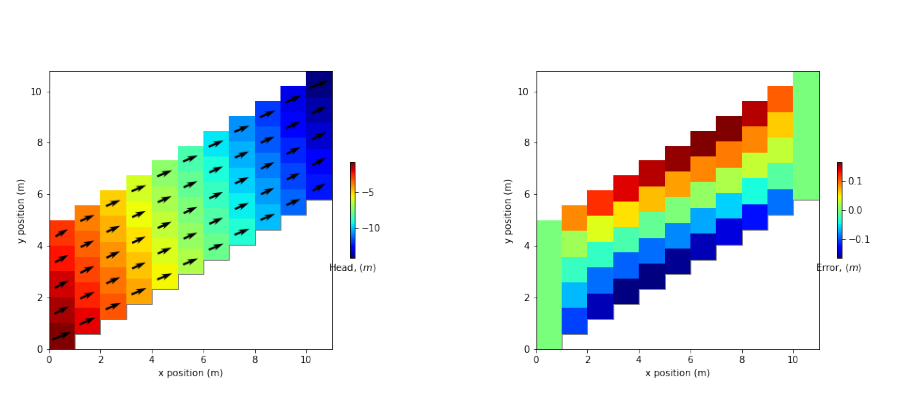

---------  ------------
sim_name   disu-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00000000286749  30.00000006939752
avg channel  1.00000000065810  30.00000006765153
min channel  0.99999990614908  29.99999668993714
max channel  1.00000010006318  30.00000310456373


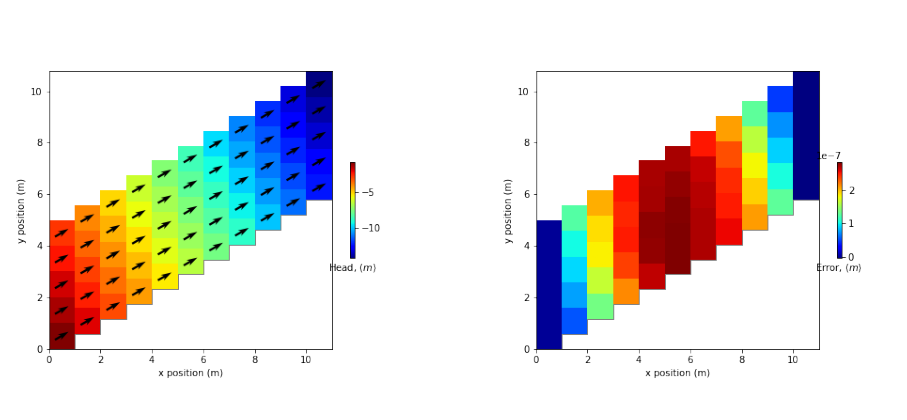

---------  ------------
sim_name   disu-cf-vo-s
crossflow  True
staggered  False
xt3d       False
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  0.86602540631520   90.00000009703990
avg channel  0.86602540524717   89.99999999438799
min channel  0.86602538603309   89.99999941752972
max channel  0.86602542337478   90.00000050815353


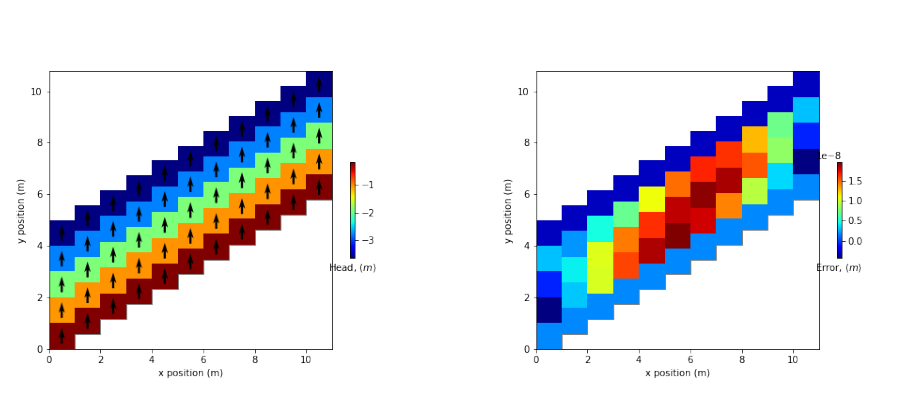

---------  ------------
sim_name   disu-cf-vo-x
crossflow  True
staggered  False
xt3d       True
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  1.00000000064935  119.99999993827650
avg channel  1.00000000159031  119.99999998324760
min channel  0.99999999621608  119.99999964981950
max channel  1.00000000709115  120.00000024041705


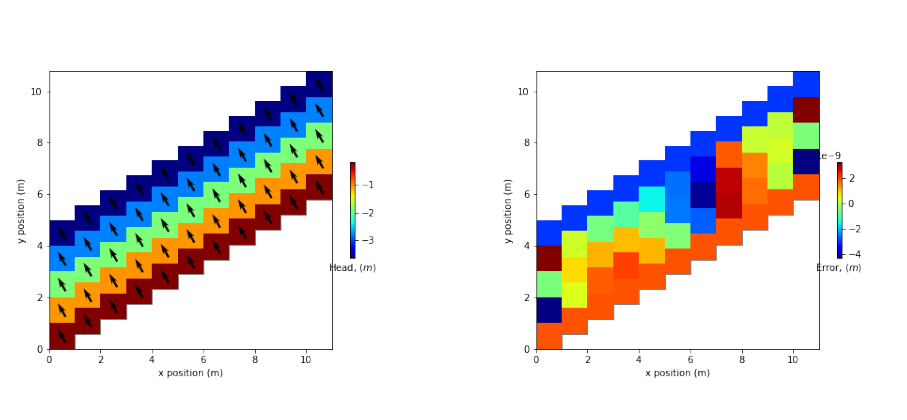

---------  ------------
sim_name   disu-cf-vs-s
crossflow  True
staggered  True
xt3d       False
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  0.96824583831330  116.56505115476394
avg channel  0.94640603446696  112.93828854091512
min channel  0.86602541000000   90.00000000000000
max channel  0.96824584310545  116.56505151032790


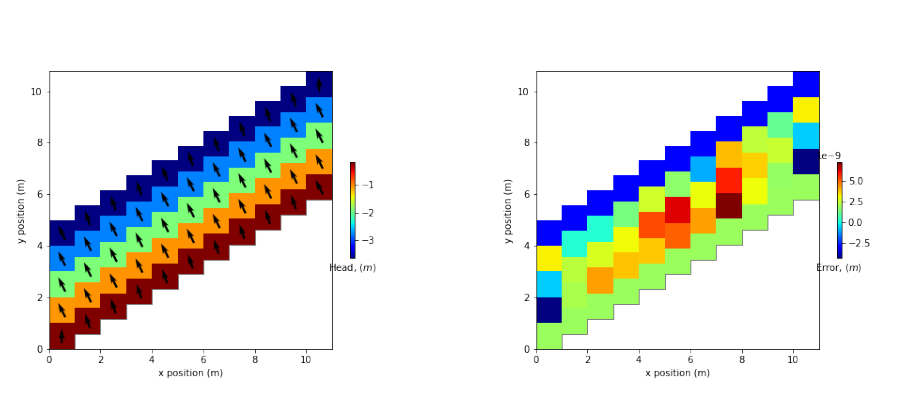

---------  ------------
sim_name   disu-cf-vs-x
crossflow  True
staggered  True
xt3d       True
---------  ------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  1.00000000126820  119.99999995373541
avg channel  1.00000000165730  119.99999999673123
min channel  0.99999999689162  119.99999982830498
max channel  1.00000000676851  120.00000024667234


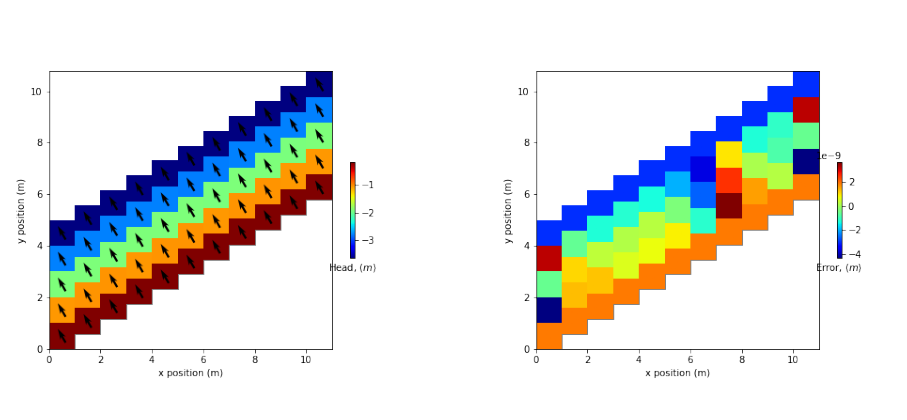

In [10]:
# run scenarios
for i in range(len(parameters)):
    simulation(i)